# Updates from last version  

* 01/07 - Initial version - AOPC metric for KSHAP
* 06/07 - updating reference input for SHAP from `<PAD>` to `<UNK>`
* 20/07 - used the last epoch mode
* 21/07 - trial with reproducing model performance with validation data
* 29/07 - LeRF explanation on ground truth class

In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import pandas as pd
import collections
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy, crf_marginal_accuracy, crf_viterbi_accuracy

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

from ner_util import pre_process_data_ner, \
                        iob_to_iob2,\
                        SentenceGetter, \
                        format_aux_input, \
                        reduce_sentence_length_by_word, \
                        pred2label, \
                        sent2features, \
                        get_f1

Using TensorFlow backend.


In [3]:
# file paths
validation_iob_tagged_file = '../data/CoNLL-2003/eng.testa'
save_best_weights = '../models/ner/bi_lstm_crf_last_epoch_weights.h5'
# '../models/ner/bi_lstm_crf_weights.h5'
vocab2int_path = '../models/ner_bilstm_crf_train_vocab2int.pkl'
# oh_encoder_path = '../models/ner_bilstm_crf_trained_oh_encoder.pkl'
# standard_transformer_path = '../models/ner_bilstm_crf_trained_standard_transform.pkl'
preprocess_transformer_path = '../models/ner_bilstm_crf_trained_pre-proc_transform.pkl'
tag2idx_path = '../models/ner_bilstm_crf_tag2idx.pkl'
idx2tag_path = '../models/ner_bilstm_crf_idx2tag.pkl'

In [4]:
# other configurations
max_words = 25
max_len = 25
n_tags = 9
num_word_prev = 5
num_word_next = 5

## Load models

In [5]:
with (open(vocab2int_path, "rb")) as _openfile:
    vocab_to_int = pickle.load(_openfile)

In [6]:
with (open(preprocess_transformer_path, "rb")) as _openfile:
    trained_preprocess_transform = pickle.load(_openfile)

In [7]:
with (open(tag2idx_path, "rb")) as _openfile:
    tag2idx = pickle.load(_openfile)

In [8]:
tag2idx

{'B-PER': 0,
 'B-ORG': 1,
 'I-PER': 2,
 'B-MISC': 3,
 'I-ORG': 4,
 'I-LOC': 5,
 'I-MISC': 6,
 'O': 7,
 'B-LOC': 8}

In [9]:
with (open(idx2tag_path, "rb")) as _openfile:
    idx2tag = pickle.load(_openfile)

In [10]:
idx2tag

{0: 'B-PER',
 1: 'B-ORG',
 2: 'I-PER',
 3: 'B-MISC',
 4: 'I-ORG',
 5: 'I-LOC',
 6: 'I-MISC',
 7: 'O',
 8: 'B-LOC'}

In [11]:
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.set_random_seed(1234)

In [12]:
model = load_model(save_best_weights,custom_objects={'CRF': CRF,
                               'crf_loss': crf_loss,
                               'crf_viterbi_accuracy': crf_viterbi_accuracy,
                                'crf_marginal_accuracy':crf_marginal_accuracy,
                                'get_f1': get_f1})

## Hold out dataset

In [13]:
validate_iob_tag_df = pd.read_csv(validation_iob_tagged_file,delimiter=' ',skip_blank_lines=False, 
                                  header = None, names = ['word','pos','chunk','tag'])
validate_iob_tag_df.head()

,word,pos,chunk,tag
0,-DOCSTART-,-X-,O,O
1,NaN,NaN,NaN,NaN
2,CRICKET,NNP,I-NP,O
3,-,:,O,O
4,LEICESTERSHIRE,NNP,I-NP,I-ORG


In [14]:
validate_iob_tagged_df_cleaned = pre_process_data_ner(validate_iob_tag_df)
validate_iob_tagged_df_cleaned.isna().sum()

word            0
pos             0
chunk           0
tag             0
sentence_num    0
doc_num         0
dtype: int64

In [15]:
validate_tag_counts = collections.Counter(validate_iob_tagged_df_cleaned["tag"])
validate_tag_counts

Counter({'O': 42120,
         'I-ORG': 2092,
         'I-LOC': 2094,
         'I-MISC': 1264,
         'I-PER': 3145,
         'B-MISC': 4})

In [16]:
validate_iob_tagged_df_cleaned["iob2_tag"] = iob_to_iob2(validate_iob_tagged_df_cleaned)
validate_iob_tagged_df_cleaned["iob2_chunk"] = iob_to_iob2(validate_iob_tagged_df_cleaned,'chunk')
validate_iob_tagged_df_cleaned.head()

,word,pos,chunk,tag,sentence_num,doc_num,iob2_tag,iob2_chunk
2,CRICKET,NNP,I-NP,O,0,0,O,B-NP
3,-,:,O,O,0,0,O,O
4,LEICESTERSHIRE,NNP,I-NP,I-ORG,0,0,B-ORG,B-NP
5,TAKE,NNP,I-NP,O,0,0,O,I-NP
6,OVER,IN,I-PP,O,0,0,O,B-PP


In [17]:
validate_iob_tagged_df_cleaned.drop(['chunk','tag'], axis = 1, inplace = True)
validate_iob_tagged_df_cleaned.rename(columns = {'iob2_tag':'tag',
                                              'iob2_chunk':'chunk'}, inplace = True)

In [18]:
validate_iob_tagged_df_cleaned_reduced = reduce_sentence_length_by_word(validate_iob_tagged_df_cleaned,
                                                                     max_words,'sentence_num')
validate_iob_tagged_df_cleaned_reduced.shape

(24988, 6)

In [19]:
validate_tag_counts = collections.Counter(validate_iob_tagged_df_cleaned_reduced["tag"])
validate_tag_counts

Counter({'O': 20121,
         'B-ORG': 839,
         'B-LOC': 1180,
         'B-PER': 1008,
         'I-PER': 675,
         'B-MISC': 460,
         'I-MISC': 193,
         'I-LOC': 156,
         'I-ORG': 356})

In [20]:
validate_getter = SentenceGetter(validate_iob_tagged_df_cleaned_reduced)
validate_sentences = validate_getter.sentences

In [21]:
X_validate = [[vocab_to_int[w[0]] if w[0] in vocab_to_int.keys() else vocab_to_int['<UNK>'] for w in s]\
                                                            for s in validate_sentences]
X_validate = pad_sequences(maxlen = max_len, sequences = X_validate, 
                        padding  = 'post', value = vocab_to_int['<PAD>'])
len(X_validate[0])

25

In [22]:
y_validate = [[tag2idx[w[3]] for w in s] for s in validate_sentences]
y_validate = pad_sequences(maxlen = max_len, sequences = y_validate, padding  = 'post', value = tag2idx['O'])

In [23]:
y_validate = [to_categorical(i, num_classes = n_tags) for i in y_validate]

In [24]:
X_aux_validate =  [sent2features(s, num_word_prev, num_word_next, max_len) for s in validate_sentences]
len(X_aux_validate), len(X_aux_validate[0])

(2505, 25)

In [25]:
aux_validate_input, _ = format_aux_input(X_aux_validate, max_len = max_len,
                                     preproc_transform = trained_preprocess_transform)
              #oh_encoder = trained_oh_encoder, standard_transform = trained_standard_transform)
aux_validate_input.shape

D:\Anaconda\envs\XAI_NER\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


(2505, 25, 2684)

In [26]:
validate_pred = model.predict([X_validate,aux_validate_input], verbose=1)

2505/2505 [==============================] - 12s 5ms/step


In [27]:
validate_pred.shape

(2505, 25, 9)

In [28]:
validate_pred_labels = pred2label(validate_pred, idx2tag)
validate_labels = pred2label(y_validate, idx2tag)

In [29]:
print("F1-score: {:.1%}".format(f1_score(validate_labels, validate_pred_labels)))
print(classification_report(validate_labels, validate_pred_labels))

F1-score: 81.7%
           precision    recall  f1-score   support

      LOC       0.94      0.85      0.89      1180
      ORG       0.76      0.81      0.78       839
      PER       0.72      0.86      0.78      1008
     MISC       0.75      0.80      0.77       460

micro avg       0.80      0.84      0.82      3487
macro avg       0.81      0.84      0.82      3487



## Prepare for explanation

We'll choose observations where there is at least one predicted entity of type location (best performing) or misc (worst performing) and where the probability score is more than 0.95.  
Then we'll need to choose the pair of tags for comparison. The output of this activity should be a data frame containing:
- sentence in raw form
- word index in the sentence for B-LOC / I-LOC tag (having probability more than 0.95)
- whether the prediction is correct
- the other tag for comparison
- word index in the sentence for B-MISC / I-MISC tag (having probability more than 0.95)
- whether the prediction is correct
- the other tag for comparison

In [30]:
import numpy as np
import random
from explanation_util import get_entity_prediction, \
                            get_explanation_instances

In [31]:
validate_entity_prob_mat, idx2ent = get_entity_prediction(validate_pred, idx2tag)
validate_true_entity_prob_mat, idx2ent_true = get_entity_prediction(y_validate, idx2tag)
validate_pred.shape, validate_entity_prob_mat.shape, validate_true_entity_prob_mat.shape, len(idx2ent)

((2505, 25, 9), (2505, 25, 5), (2505, 25, 5), 5)

In [32]:
expl_selected_dict = get_explanation_instances(validate_entity_prob_mat, validate_true_entity_prob_mat, 
                                               idx2ent, idx2ent_true, selection_prob = 0.6)

In [33]:
print_dict = {k:v for i,(k,v) in enumerate(expl_selected_dict.items()) if i < 5}
print_dict

{(1, 'LOC', 0.9994305968284607): {'word_indx': [0],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 6.97830764693208e-05,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (3, 'LOC', 0.9608662128448486): {'word_indx': [5],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 0.03692855313420296,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (6, 'MISC', 0.9964298407236735): {'word_indx': [2, 3, 4],
  'p_i': 3,
  'p_i_next': 4,
  'pred_tag_next': 'O',
  'p_next': 0.0012798189003054479,
  'is_accurate': True,
  'actual_tag': ['MISC', 'MISC', 'MISC']},
 (7, 'LOC', 0.9994305968284607): {'word_indx': [0],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 6.97830764693208e-05,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (8, 'MISC', 0.9997373223304749): {'word_indx': [7],
  'p_i': 3,
  'p_i_next': 4,
  'pred_tag_next': 'O',
  'p_next': 4.0323371649719775e-05,
  'is_accurate': True,
  'actual_tag': ['MISC']}}

In [34]:
# only multi word for explanation
expl_selected_multiword_dict = {key: expl_selected_dict[key] 
                                for key in expl_selected_dict.keys()
                                if len(expl_selected_dict[key]['word_indx']) > 1}

len(expl_selected_multiword_dict)

242

In [35]:
#create two different dict for correct and wrong predictions
expl_selected_multiword_accurate_dict = {key: expl_selected_multiword_dict[key] 
                                for key in expl_selected_multiword_dict.keys()
                                if expl_selected_multiword_dict[key]['is_accurate'] and 
                                        len(validate_sentences[key[0]]) > 6}

# expl_selected_multiword_wrong_dict = {key: expl_selected_multiword_dict[key] 
#                                 for key in expl_selected_multiword_dict.keys()
#                                 if not expl_selected_multiword_dict[key]['is_accurate']}

expl_selected_wrong_dict = {key: expl_selected_dict[key] 
                                for key in expl_selected_dict.keys()
                                if not expl_selected_dict[key]['is_accurate'] and 
                           len(validate_sentences[key[0]]) > 6}


len(expl_selected_multiword_accurate_dict), len(expl_selected_wrong_dict)

(159, 74)

In [36]:
#create two different dict for correct LOC and MISC predictions
expl_selected_multiword_accurate_dict_LOC = {key: expl_selected_multiword_accurate_dict[key] 
                                for key in expl_selected_multiword_accurate_dict.keys()
                                if key[1] == 'LOC'}

expl_selected_multiword_accurate_dict_MISC = {key: expl_selected_multiword_accurate_dict[key] 
                                for key in expl_selected_multiword_accurate_dict.keys()
                                if key[1] == 'MISC'}

len(expl_selected_multiword_accurate_dict_LOC), len(expl_selected_multiword_accurate_dict_MISC)

(67, 92)

In [37]:
#create two different dict for incorrect LOC and MISC predictions
expl_selected_wrong_dict_LOC = {key: value 
                                for key, value in expl_selected_wrong_dict.items()
                                if 'LOC' in value['actual_tag']}

expl_selected_wrong_dict_MISC = {key: value 
                                for key, value in expl_selected_wrong_dict.items()
                                if 'MISC' in value['actual_tag']}

len(expl_selected_wrong_dict_LOC), len(expl_selected_wrong_dict_MISC)

(13, 9)

In [38]:
# 10 random selection from each of correct prediction dict to limit computation
random.seed(32)
expl_accurate_random_multiword_keys_LOC = random.sample(expl_selected_multiword_accurate_dict_LOC.keys(),10)
expl_accurate_random_multiword_dict_LOC = {rnd_key: expl_selected_multiword_accurate_dict_LOC[rnd_key] for \
                                           rnd_key in expl_accurate_random_multiword_keys_LOC}
random.seed(32)
expl_accurate_random_multiword_keys_MISC = random.sample(expl_selected_multiword_accurate_dict_MISC.keys(),10)
expl_accurate_random_multiword_dict_MISC = {rnd_key: expl_selected_multiword_accurate_dict_MISC[rnd_key] for \
                                           rnd_key in expl_accurate_random_multiword_keys_MISC}

len(expl_accurate_random_multiword_dict_LOC),len(expl_accurate_random_multiword_dict_MISC)

(10, 10)

In [40]:
# 10 random selection from each of correct prediction dict to limit computation
if len(expl_selected_wrong_dict_LOC) > 10:
    random.seed(32)
    expl_inaccurate_random_multiword_keys_LOC = random.sample(expl_selected_wrong_dict_LOC.keys(),10)
    expl_selected_wrong_dict_LOC = {rnd_key: expl_selected_wrong_dict_LOC[rnd_key] for \
                                               rnd_key in expl_inaccurate_random_multiword_keys_LOC}

if len(expl_selected_wrong_dict_MISC) > 10:
    random.seed(32)
    expl_inaccurate_random_multiword_keys_MISC = random.sample(expl_selected_wrong_dict_MISC.keys(),10)
    expl_selected_wrong_dict_MISC = {rnd_key: expl_selected_wrong_dict_MISC[rnd_key] for \
                                               rnd_key in expl_inaccurate_random_multiword_keys_MISC}

len(expl_selected_wrong_dict_LOC),len(expl_selected_wrong_dict_MISC)

(10, 9)

In [41]:
index = 6
#label = tag2idx[index]
text = validate_sentences[index]
print(text)

[('CRICKET', 'NNP', 'B-NP', 'O'), ('-', ':', 'O', 'O'), ('ENGLISH', 'JJ', 'B-NP', 'B-MISC'), ('COUNTY', 'NNS', 'I-NP', 'I-MISC'), ('CHAMPIONSHIP', 'WDT', 'B-NP', 'I-MISC'), ('SCORES', 'NNP', 'I-NP', 'O'), ('.', '.', 'O', 'O')]


In [42]:
test_sent = " ".join([x[0] for x in text])
test_sent

'CRICKET - ENGLISH COUNTY CHAMPIONSHIP SCORES .'

In [43]:
sent_getter_id_dict = {" ".join([x[0] for x in text]):i for i, text in enumerate(validate_sentences)}

In [44]:
sent_word_getter_id_dict = {i:{(j,words[0]):words for j, words in enumerate(text)} for i, text in enumerate(validate_sentences)}

In [45]:
sent_word_getter_id_dict[10]

{(0, 'Somerset'): ('Somerset', 'NNP', 'B-NP', 'B-ORG'),
 (1, '83'): ('83', 'CD', 'I-NP', 'O'),
 (2, 'and'): ('and', 'CC', 'I-NP', 'O'),
 (3, '174'): ('174', 'CD', 'I-NP', 'O'),
 (4, '('): ('(', '(', 'O', 'O'),
 (5, 'P.'): ('P.', 'NNP', 'B-NP', 'B-PER'),
 (6, 'Simmons'): ('Simmons', 'NNP', 'I-NP', 'I-PER'),
 (7, '4-38'): ('4-38', 'CD', 'I-NP', 'O'),
 (8, ')'): (')', ')', 'O', 'O'),
 (9, ','): (',', ',', 'O', 'O'),
 (10, 'Leicestershire'): ('Leicestershire', 'NNP', 'B-NP', 'B-ORG'),
 (11, '296'): ('296', 'CD', 'I-NP', 'O'),
 (12, '.'): ('.', '.', 'O', 'O')}

## Kernel SHAP for NER

In [46]:
from explanation_util import NER_KSHAPExplainerGenerator
from matplotlib import pyplot as plt
import shap

In [47]:
KSHAP_explainer_generator = NER_KSHAPExplainerGenerator(model, vocab_to_int, tag2idx, max_len, 
                                            sent_getter_id_dict, sent_word_getter_id_dict,
                                            validate_sentences, trained_preprocess_transform,
                                                       num_word_next = num_word_next,
                num_word_prev = num_word_prev)

In [48]:
list(idx2ent.values())

['PER', 'LOC', 'ORG', 'MISC', 'O']

In [49]:
ent2idx = {v:k for k, v in idx2ent.items()}
ent2idx

{'PER': 0, 'LOC': 1, 'ORG': 2, 'MISC': 3, 'O': 4}

In [50]:
text = validate_sentences[159]
explian_text = " ".join([x[0] for x in text])
explian_text

'Amanda Coetzer ( South Africa ) beat Irina Spirlea ( Romania ) 7-6 ( 7-5 ) 7-5'

In [51]:
flat_input_list, flat_feature_list  = KSHAP_explainer_generator.preprocess([explian_text])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 276ms/step


In [52]:
len(flat_feature_list[0])

67125

In [53]:
predict_func = KSHAP_explainer_generator.get_predict_function(word_index_list= [3, 4])
entity_pred_sample = predict_func(flat_input_list)
entity_pred_sample

array([[5.42993347e-05, 9.99099076e-01, 1.23877368e-04, 1.77513490e-04,
        4.61313303e-07]])

In [54]:
# ref_text = "<PAD>"
# changed from <PAD>
ref_text = ("<UNK> " * max_words).strip()
ref_flat_input, _ = KSHAP_explainer_generator.preprocess([ref_text])
ref_flat_input.shape, flat_input_list.shape

1/1 [==============================] - 0s 64ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((1, 67125), (1, 67125))

### AOPC for Kernel SHAP explanation

In [55]:
from explanation_validation_util import get_KSHAP_explanation_feature_list, \
                                KSHAP_perturb_for_AOPC, AOPC

In [56]:
shap.initjs()
KSHAP_expl_word_list_inaccurate_LOC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                validate_sentences, expl_selected_wrong_dict_LOC,
                                                                grnd_truth_explanation = True, ent2idx = ent2idx)

1/1 [==============================] - 0s 73ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 263ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 300ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 288ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 269ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 285ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 249ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 353ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 266ms/step


In [57]:
KSHAP_expl_word_list_accurate_LOC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                validate_sentences, expl_accurate_random_multiword_dict_LOC)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 278ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 316ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 264ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 348ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 441ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 285ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 286ms/step


In [58]:
shap.initjs()
KSHAP_expl_word_list_inaccurate_MISC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                          validate_sentences, expl_selected_wrong_dict_MISC,
                                                                grnd_truth_explanation = True, ent2idx = ent2idx)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 391ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 210ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 295ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 379ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 300ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 283ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 275ms/step


In [59]:
shap.initjs()
KSHAP_expl_word_list_accurate_MISC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                 validate_sentences, expl_accurate_random_multiword_dict_MISC)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 1s 547ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 370ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 379ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 369ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 285ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 367ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 285ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 267ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 338ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 99ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 84ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 78ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 84ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 81ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 94ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 92ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 104ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[<matplotlib.lines.Line2D at 0x1901671ac88>]

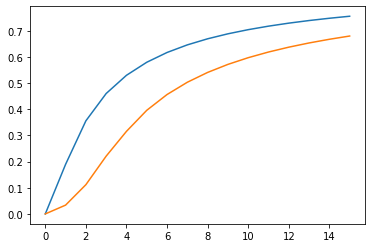

In [60]:
KSHAP_LOC_accurate_AOPC_MoRF_list, KSHAP_LOC_accurate_AOPC_leRF_list = AOPC(KSHAP_explainer_generator,
                                                                            KSHAP_expl_word_list_accurate_LOC, 
                                                                            ent2idx = ent2idx, vocab_to_int = vocab_to_int, 
                                                                            expalanation_func = 'KSHAP', L = 15)

plt.plot(KSHAP_LOC_accurate_AOPC_MoRF_list)
plt.plot(KSHAP_LOC_accurate_AOPC_leRF_list)

1/1 [==============================] - 0s 78ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 93ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 82ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 94ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 79ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 88ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 97ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 97ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 87ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[<matplotlib.lines.Line2D at 0x1902f5ea7f0>]

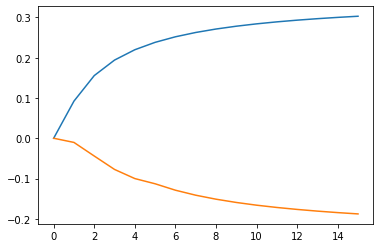

In [61]:
KSHAP_LOC_inaccurate_AOPC_MoRF_list, KSHAP_LOC_inaccurate_AOPC_leRF_list = AOPC(KSHAP_explainer_generator,
                                                                                KSHAP_expl_word_list_inaccurate_LOC, 
                                                                                ent2idx = ent2idx, vocab_to_int = vocab_to_int, 
                                                                                expalanation_func = 'KSHAP', L = 15)

plt.plot(KSHAP_LOC_inaccurate_AOPC_MoRF_list)
plt.plot(KSHAP_LOC_inaccurate_AOPC_leRF_list)

1/1 [==============================] - 0s 84ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 92ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 77ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 94ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 83ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 87ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 89ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 84ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 87ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 86ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[<matplotlib.lines.Line2D at 0x18f9e620ac8>]

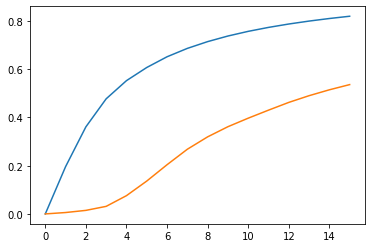

In [62]:
KSHAP_MISC_accurate_AOPC_MoRF_list, KSHAP_MISC_accurate_AOPC_leRF_list = AOPC(KSHAP_explainer_generator,
                                                                              KSHAP_expl_word_list_accurate_MISC, 
                                                                              ent2idx = ent2idx, vocab_to_int = vocab_to_int, 
                                                                              expalanation_func = 'KSHAP', L = 15)
plt.plot(KSHAP_MISC_accurate_AOPC_MoRF_list)
plt.plot(KSHAP_MISC_accurate_AOPC_leRF_list)

1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 95ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 101ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 131ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 78ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 100ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 85ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 90ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 98ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[<matplotlib.lines.Line2D at 0x1902edd6c18>]

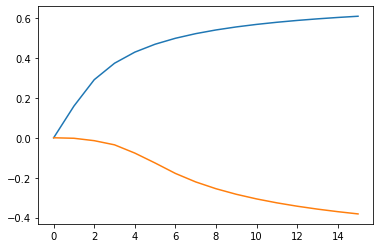

In [63]:
KSHAP_MISC_inaccurate_AOPC_MoRF_list, KSHAP_MISC_inaccurate_AOPC_leRF_list = AOPC(KSHAP_explainer_generator,
                                                                                  KSHAP_expl_word_list_inaccurate_MISC, 
                                                                            ent2idx = ent2idx, vocab_to_int = vocab_to_int,
                                                                            expalanation_func = 'KSHAP', L = 15)
plt.plot(KSHAP_MISC_inaccurate_AOPC_MoRF_list)
plt.plot(KSHAP_MISC_inaccurate_AOPC_leRF_list)

## LIME set up for NER explanation

In [64]:
from lime.lime_text import LimeTextExplainer
from explanation_util import NER_LIMEExplainerGenerator

In [65]:
LIME_explainer_generator = NER_LIMEExplainerGenerator(model, vocab_to_int, tag2idx, max_len, 
                                            sent_getter_id_dict, sent_word_getter_id_dict,
                                            validate_sentences, trained_preprocess_transform,
                                                     num_word_next = num_word_next,
                num_word_prev = num_word_prev)

In [66]:
list(idx2ent.values())

['PER', 'LOC', 'ORG', 'MISC', 'O']

In [80]:
# classes and the entity names
LIME_explainer = LimeTextExplainer(class_names=list(idx2ent.values()),bow = False, split_expression= " ")


## Explanation quantitative metrics - AOPC

In [81]:
from matplotlib import pyplot as plt
from explanation_validation_util import get_LIME_explanation_word_list, \
                            LIME_perturb_for_AOPC

In [82]:
LIME_expl_word_list_inaccurate_LOC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                    validate_sentences, expl_selected_wrong_dict_LOC,
                                                                grnd_truth_explanation = True, ent2idx = ent2idx)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
LIME_expl_word_list_accurate_LOC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                  validate_sentences, expl_accurate_random_multiword_dict_LOC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [84]:
LIME_expl_word_list_inaccurate_MISC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                     validate_sentences, expl_selected_wrong_dict_MISC,
                                                                grnd_truth_explanation = True, ent2idx = ent2idx)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
LIME_expl_word_list_accurate_MISC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                   validate_sentences, expl_accurate_random_multiword_dict_MISC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[<matplotlib.lines.Line2D at 0x190e454f400>]

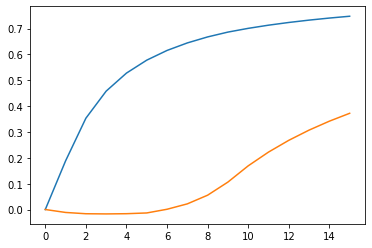

In [147]:
LIME_LOC_accurate_AOPC_MoRF_list, LIME_LOC_accurate_AOPC_leRF_list = AOPC(LIME_explainer_generator,
                                                                          LIME_expl_word_list_accurate_LOC, 
                                                                          vocab_to_int = vocab_to_int, 
                                                                          ent2idx = ent2idx, expalanation_func = 'LIME', L = 15)

plt.plot(LIME_LOC_accurate_AOPC_MoRF_list)
plt.plot(LIME_LOC_accurate_AOPC_leRF_list)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[<matplotlib.lines.Line2D at 0x19036d839b0>]

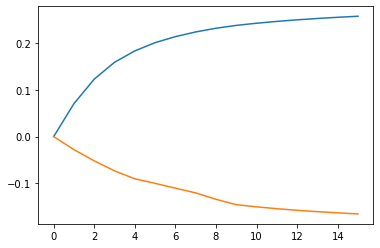

In [148]:
LIME_LOC_inaccurate_AOPC_MoRF_list, LIME_LOC_inaccurate_AOPC_leRF_list = AOPC(LIME_explainer_generator,
                                                                              LIME_expl_word_list_inaccurate_LOC,
                                                                              vocab_to_int = vocab_to_int,  
                                                                              ent2idx = ent2idx, expalanation_func = 'LIME', L = 15)

plt.plot(LIME_LOC_inaccurate_AOPC_MoRF_list)
plt.plot(LIME_LOC_inaccurate_AOPC_leRF_list)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[<matplotlib.lines.Line2D at 0x190343cba20>]

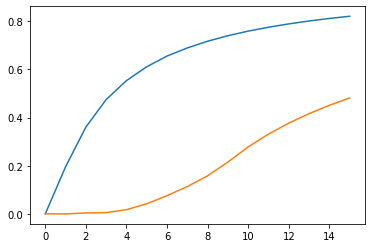

In [149]:
LIME_MISC_accurate_AOPC_MoRF_list, LIME_MISC_accurate_AOPC_leRF_list = AOPC(LIME_explainer_generator,
                                                                            LIME_expl_word_list_accurate_MISC,
                                                                            vocab_to_int = vocab_to_int, 
                                                                            ent2idx = ent2idx, expalanation_func = 'LIME', L = 15)
plt.plot(LIME_MISC_accurate_AOPC_MoRF_list)
plt.plot(LIME_MISC_accurate_AOPC_leRF_list)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

[<matplotlib.lines.Line2D at 0x190d71fb3c8>]

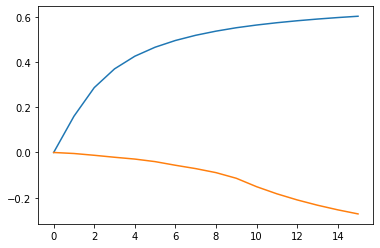

In [150]:
LIME_MISC_inaccurate_AOPC_MoRF_list, LIME_MISC_inaccurate_AOPC_leRF_list = AOPC(LIME_explainer_generator,
                                                                                LIME_expl_word_list_inaccurate_MISC,
                                                                                vocab_to_int = vocab_to_int, 
                                                                            ent2idx = ent2idx, expalanation_func = 'LIME', L = 15)
plt.plot(LIME_MISC_inaccurate_AOPC_MoRF_list)
plt.plot(LIME_MISC_inaccurate_AOPC_leRF_list)

### LIME and KSHAP AOPC comparison

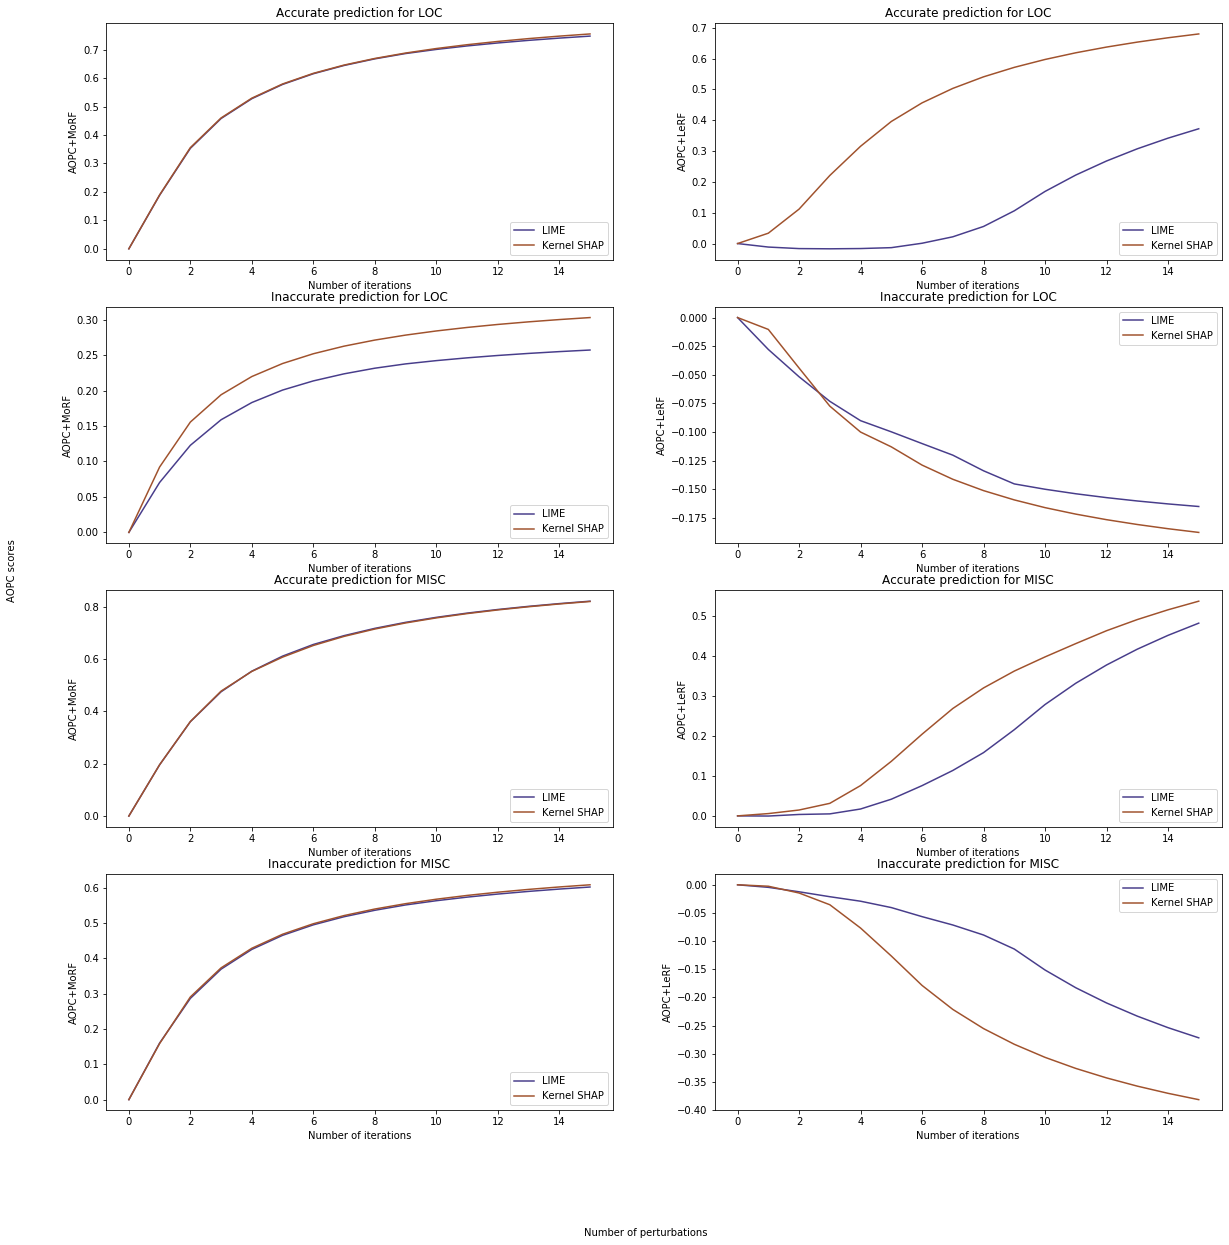

In [151]:
LIME_colour = 'darkslateblue'
KSHAP_colour = 'sienna'

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

# LOC
axes[0,0].plot(LIME_LOC_accurate_AOPC_MoRF_list, c = LIME_colour, label='LIME')
axes[0,0].plot(KSHAP_LOC_accurate_AOPC_MoRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[0,0].legend(loc="lower right")
axes[0,0].set_title('Accurate prediction for LOC')
axes[0,0].set_xlabel('Number of iterations')
axes[0,0].set_ylabel('AOPC+MoRF')

axes[0,1].plot(LIME_LOC_accurate_AOPC_leRF_list, c = LIME_colour, label='LIME')
axes[0,1].plot(KSHAP_LOC_accurate_AOPC_leRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[0,1].legend(loc="lower right")
axes[0,1].set_title('Accurate prediction for LOC')
axes[0,1].set_xlabel('Number of iterations')
axes[0,1].set_ylabel('AOPC+LeRF')

axes[1,0].plot(LIME_LOC_inaccurate_AOPC_MoRF_list, c = LIME_colour, label='LIME')
axes[1,0].plot(KSHAP_LOC_inaccurate_AOPC_MoRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[1,0].legend(loc="lower right")
axes[1,0].set_title('Inaccurate prediction for LOC')
axes[1,0].set_xlabel('Number of iterations')
axes[1,0].set_ylabel('AOPC+MoRF')

axes[1,1].plot(LIME_LOC_inaccurate_AOPC_leRF_list, c = LIME_colour, label='LIME')
axes[1,1].plot(KSHAP_LOC_inaccurate_AOPC_leRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[1,1].legend(loc="upper right")
axes[1,1].set_title('Inaccurate prediction for LOC')
axes[1,1].set_xlabel('Number of iterations')
axes[1,1].set_ylabel('AOPC+LeRF')

# MISC

axes[2,0].plot(LIME_MISC_accurate_AOPC_MoRF_list, c = LIME_colour, label='LIME')
axes[2,0].plot(KSHAP_MISC_accurate_AOPC_MoRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[2,0].legend(loc="lower right")
axes[2,0].set_title('Accurate prediction for MISC')
axes[2,0].set_xlabel('Number of iterations')
axes[2,0].set_ylabel('AOPC+MoRF')

axes[2,1].plot(LIME_MISC_accurate_AOPC_leRF_list, c = LIME_colour, label='LIME')
axes[2,1].plot(KSHAP_MISC_accurate_AOPC_leRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[2,1].legend(loc="lower right")
axes[2,1].set_title('Accurate prediction for MISC')
axes[2,1].set_xlabel('Number of iterations')
axes[2,1].set_ylabel('AOPC+LeRF')

axes[3,0].plot(LIME_MISC_inaccurate_AOPC_MoRF_list, c = LIME_colour, label='LIME')
axes[3,0].plot(KSHAP_MISC_inaccurate_AOPC_MoRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[3,0].legend(loc="lower right")
axes[3,0].set_title('Inaccurate prediction for MISC')
axes[3,0].set_xlabel('Number of iterations')
axes[3,0].set_ylabel('AOPC+MoRF')

axes[3,1].plot(LIME_MISC_inaccurate_AOPC_leRF_list, c = LIME_colour, label='LIME')
axes[3,1].plot(KSHAP_MISC_inaccurate_AOPC_leRF_list, c = KSHAP_colour, label='Kernel SHAP')
axes[3,1].legend(loc="upper right")
axes[3,1].set_title('Inaccurate prediction for MISC')
axes[3,1].set_xlabel('Number of iterations')
axes[3,1].set_ylabel('AOPC+LeRF')
# Set common labels
f.text(0.5, 0.04, 'Number of perturbations', ha='center', va='center')
f.text(0.06, 0.5, 'AOPC scores', ha='center', va='center', rotation='vertical')
plt.show()